# Introduction

In 2011, the 'Arab Spring' erupted across the Middle East and North Africa, leading to the outbreak of the Syrian Civil War. Given its proximity, Jordan became a primary destination for a massive influx of refugees fleeing the conflict. While Jordan showed potential for economic recovery following the 2008 global financial crisis, this momentum was significantly hampered by the refugee crisis. This study, therefore, aims to analyze and quantify the multifaceted impacts of the Syrian refugee influx on Jordan.

In [188]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from functools import reduce
import numpy as np
from matplotlib.ticker import MaxNLocator


# Data Management
project_root = Path.cwd()

def get_data_path(dataname):
    data_path = project_root / 'data' / dataname
    return data_path

def get_Jordan_row(dataname, skiprow, start, end):
    get_data_path(dataname)
    tmp = pd.read_csv(get_data_path(dataname), skiprows = skiprow, sep = ',')
    tmp = tmp[tmp['Country Name'] == 'Jordan']
    tmp = tmp.loc[:, start:end].copy()
    return tmp

def transform_data(df_wide, col_name):
    df_long = df_wide.T
    df_long = df_long.reset_index()
    df_long.columns = ['Year', col_name]
    df_long['Year'] = df_long['Year'].astype(int)
    return df_long

# Jordan Refugees from Syria data
Jordan_Refugees_org = pd.read_csv(get_data_path('WorldBank_Jordan_Refugees.csv'))
Jordan_Refugees = Jordan_Refugees_org.loc[:, ['Year', 'Refugees']].copy()

Population = pd.read_csv(get_data_path('WorldBank_Population.csv'), sep = ',')
Jordan_Population = Population.loc[Population['REF_AREA_ID'] == 'JOR']
Jordan_Population = Jordan_Population.loc[:, '2000':'2022'].T
Jordan_Population = Jordan_Population.reset_index()
Jordan_Population.columns = ['Year', 'Population']
Jordan_Population['Year'] = Jordan_Population['Year'].astype(int)

# Jordan Total Water Resource data
Jordan_Water_org = pd.read_csv(get_data_path('WorldBank_totalWater.csv'))
Jordan_Water = Jordan_Water_org[Jordan_Water_org['REF_AREA_LABEL'] == 'Jordan']
Jordan_Water = Jordan_Water.iloc[0].fillna(Jordan_Water.iloc[1])
Jordan_Water = Jordan_Water.to_frame(name = 'Water')
Jordan_Water = Jordan_Water.reset_index()
Jordan_Water.columns = ['Year', 'Water']
Jordan_Water = Jordan_Water.set_index('Year')
Jordan_Water = Jordan_Water.loc['2000':'2022']
Jordan_Water.reset_index(inplace = True)
Jordan_Water['Year'] = Jordan_Water['Year'].astype(int)

data_dictionary = {
    'WorldBank_GDP.csv' : 'GDP',
    'WorldBank_gdpGrowth.csv' : 'gdpGrowth',
    'WorldBank_Inflation.csv' : 'Inflation',
    'WorldBank_Unemployment.csv' : 'Unemployment',
}

merge_data = []
for filename, col_name in data_dictionary.items():
    Jordan_wide = get_Jordan_row(filename, 4, '2000', '2022')
    Jordan_long = transform_data(Jordan_wide, col_name)
    merge_data.append(Jordan_long)

merge_data.append(Jordan_Refugees)

Jordan_indexes = reduce(lambda left, right: pd.merge(left, right, on = 'Year', how = 'outer'), merge_data)
Jordan_indexes['Water_per_Capita'] = (Jordan_Water['Water'] * 1_000_000_000) / Jordan_Population['Population']

print(Jordan_indexes)



    Year           GDP  gdpGrowth  Inflation  Unemployment  Refugees  \
0   2000  8.460790e+09   4.245712   0.666881        13.700       0.0   
1   2001  8.975815e+09   5.269958   1.772204        14.700       0.0   
2   2002  9.582511e+09   5.783808   1.832994        15.300       5.0   
3   2003  1.019563e+10   4.161668   1.630000        14.500      28.0   
4   2004  1.141171e+10   8.567214   3.361868        14.628      37.0   
5   2005  1.258900e+10   8.146595   3.493685        14.800      40.0   
6   2006  1.505698e+10   8.092975   6.251725        14.000      42.0   
7   2007  1.711044e+10   8.176170   4.743906        13.100      41.0   
8   2008  2.265872e+10   7.220386  13.971231        12.700      44.0   
9   2009  2.453788e+10   5.023710  -0.739070        12.900     138.0   
10  2010  2.713380e+10   2.314834   4.845519        12.500     198.0   
11  2011  2.952415e+10   2.737180   4.162442        12.900     193.0   
12  2012  3.163456e+10   2.429358   4.515230        12.200  2387

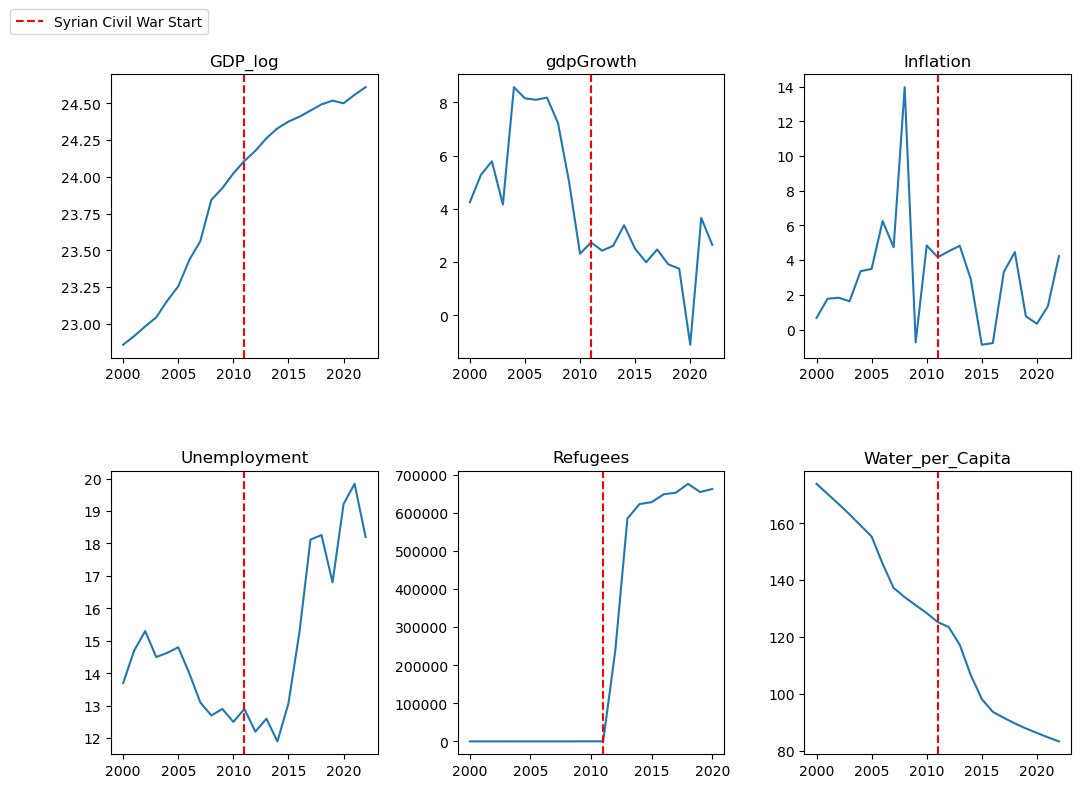

In [189]:
# Visualizing

Jordan_indexes['GDP'] = np.log(Jordan_indexes['GDP'])
Jordan_indexes = Jordan_indexes.rename(columns={'GDP' : 'GDP_log'})
Jordan_long = pd.melt(Jordan_indexes, id_vars = ['Year'], var_name = 'indicator', value_name = 'value')
indicator_list = Jordan_long['indicator'].unique()

fig, axs = plt.subplots(nrows = 2,ncols = 3, figsize = (12, 8))
for ax, indicator in zip(axs.flatten(), indicator_list):
    plot_data = Jordan_long[Jordan_long['indicator'] == indicator]
    ax.plot(plot_data['Year'], plot_data['value'])
    ax.set_title(indicator)
    ax.axvline(x=2011, color='red', linestyle='--', linewidth=1.5, label='Syrian Civil War Start')

handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.01, 0.99))
fig.subplots_adjust(
    left=0.1,      # 왼쪽 여백
    right=0.9,     # 오른쪽 여백
    top=0.9,      # 위쪽 여백 (suptitle과의 간격 확보)
    bottom=0.05,   # 아래쪽 여백
    wspace=0.3,    # 서브플롯 좌우 간격
    hspace=0.4     # 서브플롯 상하 간격
)

plt.savefig('Jordan_indexes.png')
plt.show()

# Initial Findings: Jordan's Economic Indicators

The exploratory data analysis reveals 2011 as a clear structural break for the Jordanian economy. Prior to 2011, Jordan exhibited the characteristics of a high-growth economy, with annual GDP growth rates frequently ranging between 6-8%. Post-2011, this growth trajectory stagnated significantly. This economic downturn coincides with a dramatic surge in the registered Syrian refugee population and a persistent rise in unemployment rates.


# Water Resource Data Analysis

In these indicators, there is a strange indicator. The Total Renewable Water Resources indicator presents a unique characteristic: it remains nearly constant. This is accurate, as this World Bank metric reflects a country's long-term average and does not exhibit significant annual volatility. Thus, it serves as a baseline measure of absolute water capacity.

Jordan is M.E country. For M.E, the water resource is **invaluable**. So they are sensitive about **Population**. If the population going up, they will face the critial water shortage.

Following datas show the water resource condition of Jordan.

In [190]:
# Clustering

def clustering(dataname, std, error, start, end):
    data_path = get_data_path(dataname)
    data = pd.read_csv(data_path, skiprows=4, sep=',')
    sel_columns = ['Country Code']+ [str(n) for n in range(start, end+1)]
    data_refined = data.loc[:, sel_columns]
    data_refined.set_index('Country Code', inplace=True)
    peer_countries_dict = {}
    for year in data_refined.columns:
        std_value = data_refined.loc[std, year]
        min_val = std_value * ((100-error) / 100)
        max_val = std_value * ((100+error) / 100)
        mask = data_refined[year].between(min_val, max_val)
        peer_countries = data_refined[mask].index.tolist()
        if std in peer_countries:
            peer_countries.remove(std)
        peer_countries_dict[year] = peer_countries
    return peer_countries_dict

# Economic Cluster
Jordan_cluster = clustering('WorldBank_GDP.csv', 'JOR', 10, 2000, 2022)

Water_org = pd.read_csv(get_data_path('WorldBank_totalWater.csv'))
Water_org = Water_org.set_index('REF_AREA')
Water_org = Water_org.groupby('REF_AREA').sum(numeric_only=True)
Population = Population.set_index('REF_AREA_ID')
water_cluster = {}
water_cluster_mean = {}
water_cluster_median = {}
for year, countries in Jordan_cluster.items():
    clusters = [c for c in countries if c in Water_org.index]
    water_cluster[year] = clusters

for year, clusters in water_cluster.items():
    cluster_Water = Water_org.loc[clusters, year]
    population = Population.loc[clusters, str(year)]
    per_capita_waters = (cluster_Water)*1_000_000_000/population
    water_cluster_mean[year] = per_capita_waters.mean()
    water_cluster_median[year] = per_capita_waters.median()

print(water_cluster_mean)
print(water_cluster_median)

# Geographical Cluster (Arab)
middle_east_cluster_codes = [
    'DZA', 'BHR', 'COM', 'DJI', 'EGY', 'IRQ', 'KWT',
    'LBN', 'LBY', 'MRT', 'MAR', 'OMN', 'PSE', 'QAT', 'SAU',
    'SOM', 'SDN', 'SYR', 'TUN', 'ARE', 'YEM'
]
me_water_cluster_mean = {}
me_water_cluster_median = {}
for year in range(2000, 2023):
    cluster_Water = Water_org.loc[middle_east_cluster_codes, str(year)]
    population = Population.loc[middle_east_cluster_codes, str(year)]
    per_capita_waters = (cluster_Water)*1_000_000_000/population
    me_water_cluster_mean[year] = per_capita_waters.mean()
    me_water_cluster_median[year] = per_capita_waters.median()

print(me_water_cluster_mean)
print(me_water_cluster_median)


{'2000': np.float64(73470.50226508743), '2001': np.float64(70171.61078768097), '2002': np.float64(80178.84262697102), '2003': np.float64(8098.592386290113), '2004': np.float64(14649.054780138104), '2005': np.float64(13033.674889274134), '2006': np.float64(12873.24290080898), '2007': np.float64(26000.159332092822), '2008': np.float64(39327.35999883207), '2009': np.float64(12820.442140305668), '2010': np.float64(16923.511747739438), '2011': np.float64(5600.6993794139125), '2012': np.float64(24243.506684529268), '2013': np.float64(10083.631009587183), '2014': np.float64(23293.223263574335), '2015': np.float64(19022.825436562915), '2016': np.float64(16745.568899155856), '2017': np.float64(19301.572963465016), '2018': np.float64(17943.62591136771), '2019': np.float64(11349.163158017293), '2020': np.float64(3657.3066913649673), '2021': np.float64(4798.277578547889), '2022': np.float64(10044.539012147654)}
{'2000': 9163.39613491162, '2001': 4123.985531185569, '2002': 3490.796114379726, '2003'

Before visualizing Jordan's water resource data, I want to explain my thought.

Jordan had a big change of their condition. Syria civil war outbroke in 2011, and it has been more than 10 years.
So Jordan can't join fixed group because Jordan had a lot of changes.

So, I tried **Dynamic Clustering**. Every years, I clustered countries whose have GDP within 10% from Jordan. So, the cluster of each years could be different.

And water resource is not a result of GDP. So, of course we check the GDP group, I gathered the middle east countries as **Geographic Group**.

I believe that Economic, geographic clusters make big reliability.

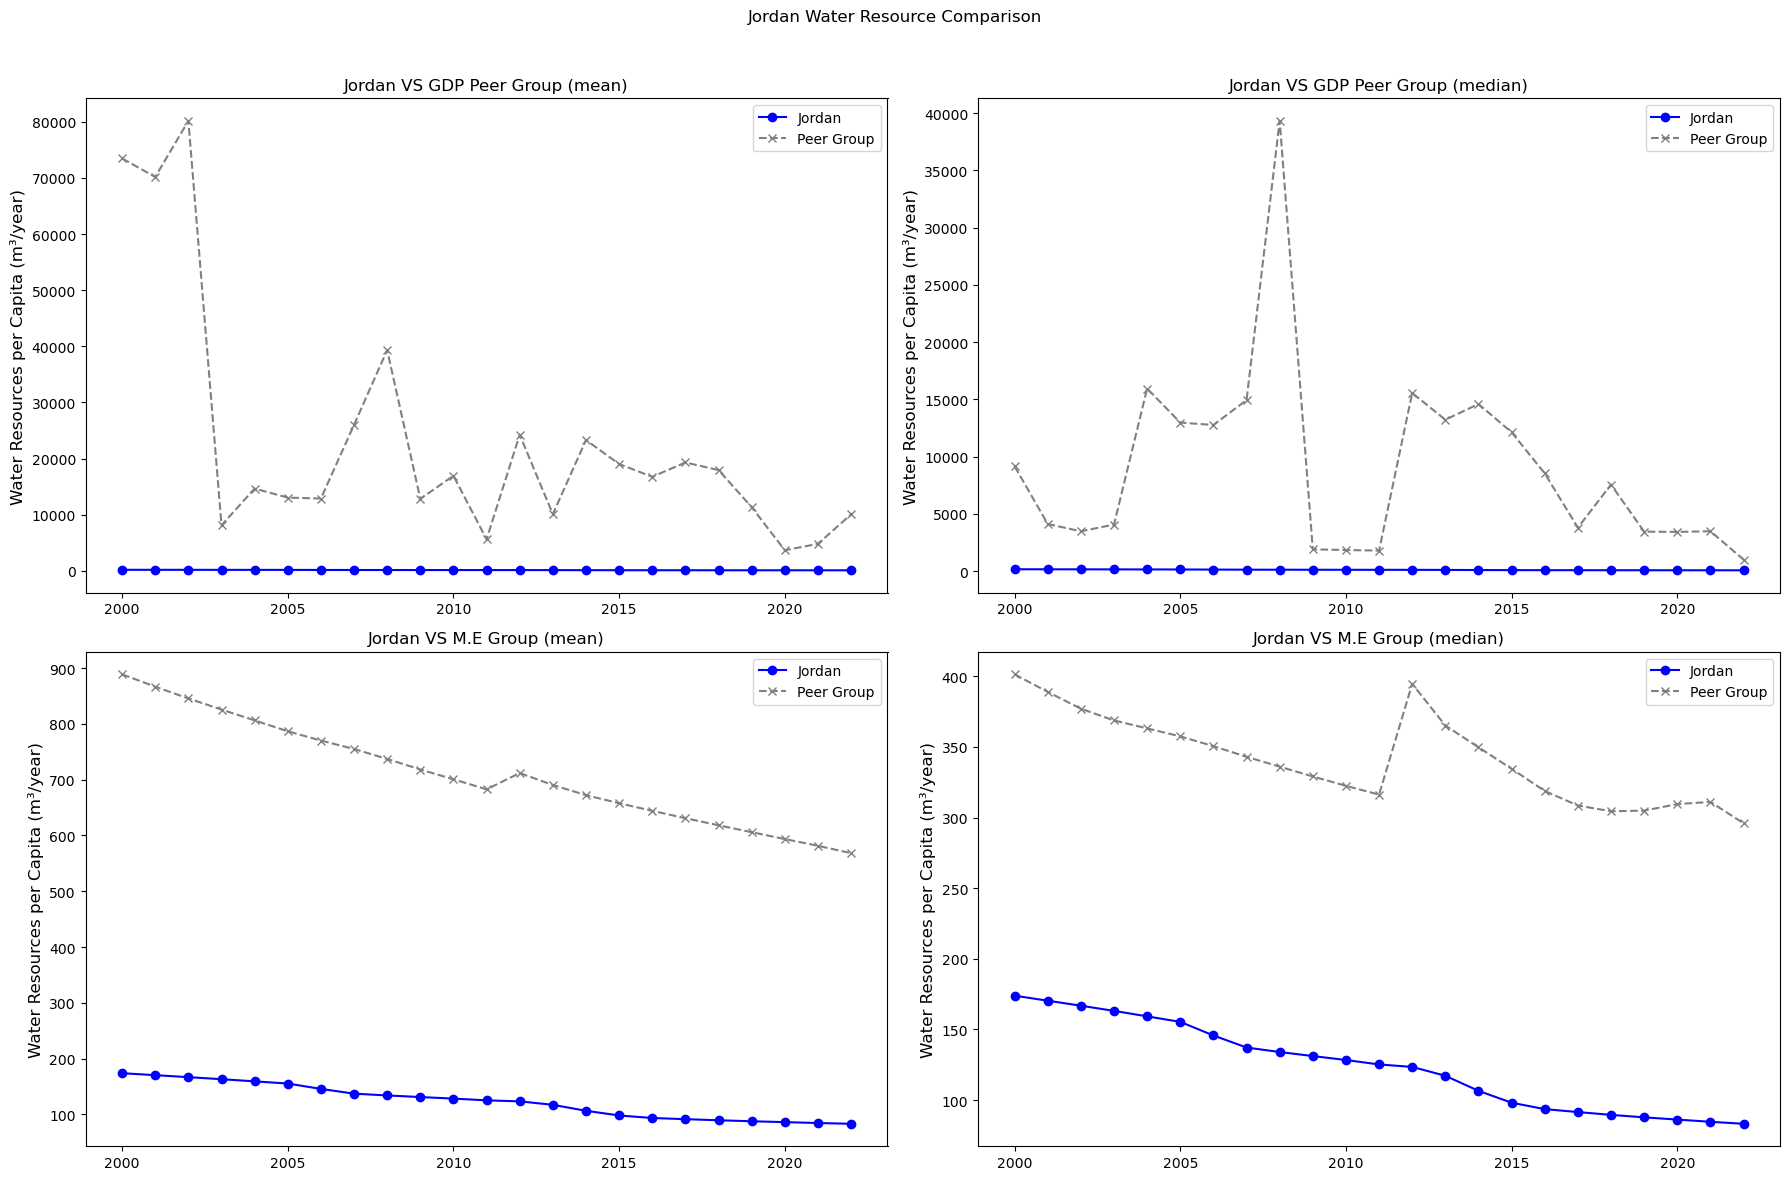

In [191]:
# Visualizing

plot_data_list = [
    (water_cluster_mean, 'Jordan VS GDP Peer Group (mean)'),
    (water_cluster_median, 'Jordan VS GDP Peer Group (median)'),
    (me_water_cluster_mean, 'Jordan VS M.E Group (mean)'),
    (me_water_cluster_median, 'Jordan VS M.E Group (median)')
]
Jordan_indexes = Jordan_indexes.set_index('Year')
fig, axs = plt.subplots(2,2, figsize = (18,12))
fig.suptitle('Jordan Water Resource Comparison')

for ax, (peer_data_dict, title) in zip(axs.flatten(), plot_data_list):
    years = [int(y) for y in peer_data_dict.keys()]
    peer_values = (peer_data_dict.values())
    ax.plot(Jordan_indexes.index, Jordan_indexes['Water_per_Capita'], label = 'Jordan', color = 'blue', marker = 'o', zorder=10)
    ax.plot(years, peer_values, label = 'Peer Group', color = 'gray', marker= 'x', linestyle = '--')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
    ax.set_title(title)
    ax.set_ylabel('Water Resources per Capita (m³/year)', fontsize = 12)
    ax.legend()

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

The comparative analysis further contextualizes this crisis through two distinct lenses:

The Economic Lens (vs. GDP Peers): When compared to a dynamic cluster of its global economic peers, Jordan is a severe outlier. Its per capita water availability is consistently an order of magnitude lower. This suggests that extreme water scarcity is a critical constraint on its economic development potential, differentiating it from other nations with similar economic output.

The Geographic Lens (vs. Middle East Peers): When compared to its neighbors in the Middle East, Jordan's situation is part of a broader regional crisis of extreme water scarcity. While still one of the most water-poor countries, its profile is less of an outlier, highlighting that the challenge is structural to the region and deeply intertwined with geopolitics.

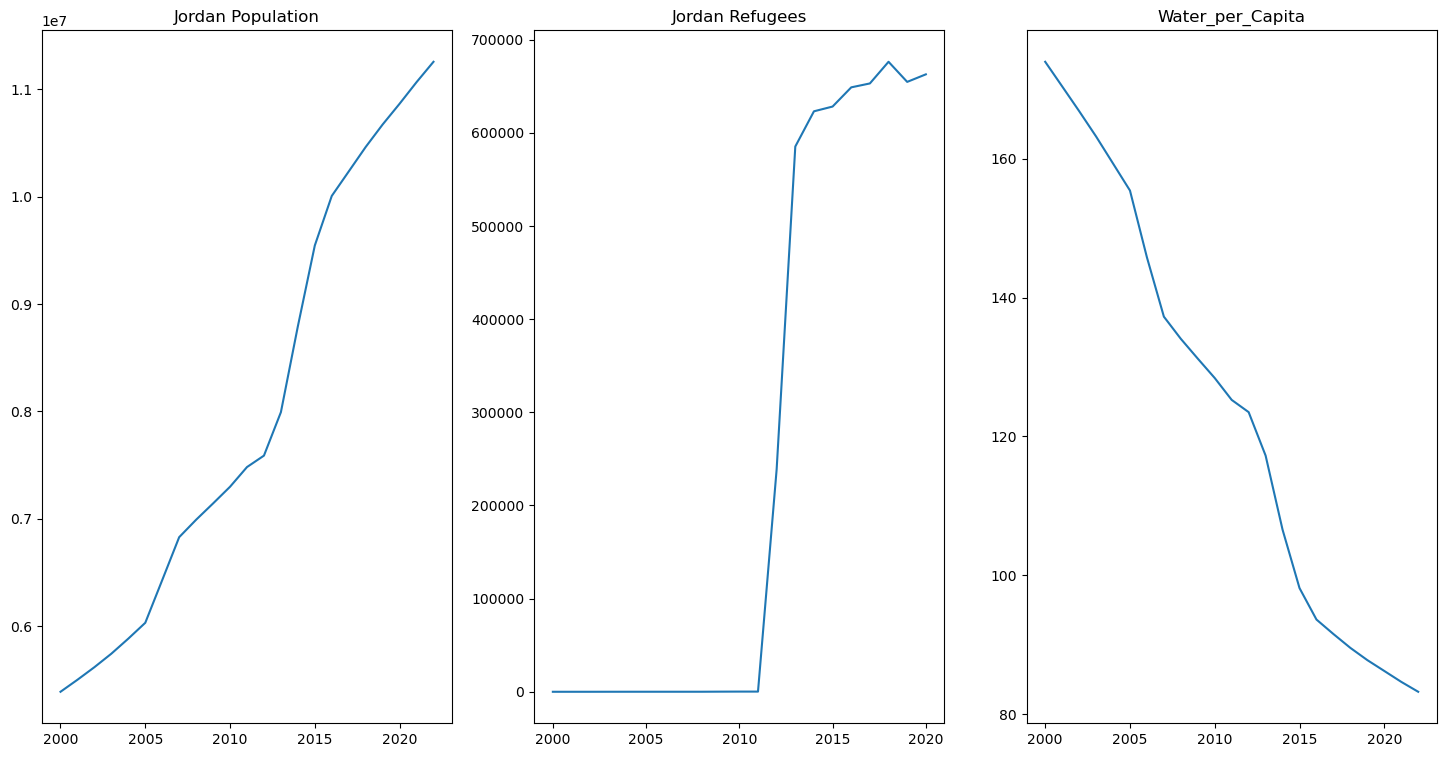

In [192]:
Jordan_indexes = pd.merge(Jordan_indexes, Jordan_Population, on = 'Year', how='outer')

fig, axs = plt.subplots(1,3, figsize = (18,9))
data_list = [
    ('Population', 'Jordan Population'),
    ('Refugees', 'Jordan Refugees'),
    ('Water_per_Capita', 'Water_per_Capita')
]

for ax, (data, name) in zip(axs.flatten(), data_list):
    ax.plot(Jordan_indexes['Year'], Jordan_indexes[data])
    ax.set_title(name)
    ax.set_xticks([2000,2005,2010,2015,2020])
plt.show()

# Core Analysis: Per Capita Water Scarcity in Context

The most critical finding emerges from the per capita water resource analysis. The massive refugee influx led to a significant population increase in Jordan. As the nation's total renewable water resources are relatively constant, this demographic shock resulted in a sharp and sustained decline in per capita water availability post-2011, pushing the nation far deeper into water poverty.

Then, why is Jordan under water crisis? First, geographic reason. Second, what I want to say is, Jordan-Israel political issue.

Following timeline is Jordan-Israel water conflictions history.

1950s - Johnston Plan: A US-mediated water-sharing plan that, while officially failing, established a technical baseline for decades of informal cooperation between Jordan and Israel.

1994 - Peace Treaty: The landmark Israel-Jordan Peace Treaty formalized relations, stipulating that Israel would provide Jordan with 50 million cubic meters (MCM) of water annually and establishing a Joint Water Committee (JWC).

2015 - Red Sea-Dead Sea Project: An ambitious joint agreement for a large-scale canal and desalination project. The project stalled, and Jordan officially withdrew in 2021, citing a lack of Israeli commitment.

2021 - Additional Water Sale: Israel agreed to sell Jordan an additional 50 MCM of water per year. However, this arrangement remains politically sensitive and unstable.

2024 Onwards - National Desalination: To reduce dependency, Jordan is pursuing its own major desalination project, the Aqaba-Amman Water Desalination and Conveyance Project (AAWDC), aiming to supply 300 MCM/year by 2029.

In conclusion, this analysis confirms that Jordan faces a condition of extreme water scarcity. This pre-existing vulnerability was severely exacerbated by the demographic shock from the Syrian refugee influx, which increased the population by over 10%. While long-term national projects like desalination represent a technical strategy for water sovereignty, they are insufficient to address the immediate crisis. This leaves Jordan critically dependent on politically sensitive water agreements with Israel. Therefore, the refugee crisis has pushed Jordan's water issue beyond a challenge that can be solved by internal technical efforts alone, making stable regional cooperation not merely beneficial, but essential for its survival and stability.